# ISMI2018 Lymphocyte Detection Project
This is the main notebook for the final ISMI2018 project.


*Detection of lymphocytes in histopathology whole-slide images of breast, colon and prostate cancer, stained with immunohistochemistry*

### Team 6
Our group consists out of four people:
* **Brian Westerweel (Data Science)** - `B.Westerweel@student.ru.nl`
* **Christoph Schmidl (Data Science)** - `c.schmidl@student.ru.nl`
* **Gijs van der Meijde (Software Science)** - `G.vanderMeijde@student.ru.nl`
* **Jeffrey Luppus (Data Science)** - `J.Luppes@student.ru.nl`

*Supervisor: Francesco Ciompi*

Group Github page: https://github.com/jeffluppes/ISMI2018 *feel free to work in branches.*

## Goals for this week (21 to 27 may)

Main goal:
* Implement U-net
* Implement f1-score evaluation

TODO list!

* Plot mask images in step 1
* U-net implementation with our masks
* try out different U-net architectures (the one I chose is pretty arbitrary)
* Manually annotate 50-60 images? 
* If someone could figure out how to commit and push directly from cartesius I would be greatful.
* Add documentation text above each significant cell
* Open source tools for annotating / isolating masks
* probabilities to centers to -> csv
first assignment -> elipsis
Loss function



Be aware of the following:

* **Next contact moment**: Monday at 10 skype call
* **Next group meeting**: Friday and Mon


## Important Deadlines

* **Mid-term presentation:** June 4, 9:00 - 12:00, room 616 Huygen building
* **Final presentation:** July 2, 9:00 - 12:00, room 616 Huygen building

## Resources
The two papers Francesco sent:

* https://openreview.net/pdf?id=rk0xLisiM
* https://openreview.net/pdf?id=S10IfW2oz

Kaggle Contest about cell detection (Data Science Bowl 2018)

* https://www.kaggle.com/c/data-science-bowl-2018

Particular Kernels of Interest (KoIs)

* https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
* https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

Other resources

* https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6 (Christoph)
* https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM (Christoph)
* https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/ (Jeff)
* https://github.com/jocicmarko/ultrasound-nerve-segmentation (Jeff)
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ (Gijs)

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob
import csv
import random 
from tqdm import tqdm
from PIL import Image

# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dropout, UpSampling2D, core
from keras.callbacks import ModelCheckpoint


# Other
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


## General introduction
TODO once more of this takes shape we should have some kind of general introduction here where we talk about the sections to come and how they relate to each other. It should be high-level and introductionary. 

In [2]:
user = 'ruc0028' #jeffrey

## Cartesius file paths

In [3]:
train_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images'
validation_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images'
test_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/test_images'
train_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/training_annotations.csv'
data_dir = '/home/'+user+'/Project/data'
train_masks_dir = data_dir+'/train_masks'

## If the jupyter server runs locally

In [2]:
train_dir = 'train_images'
train_masks_dir = 'train_masks'
train_points = 'training_annotations.csv'

### Creating Circle Masks

In [11]:
def split(x):
    return x.split(', ')

def createSquareMask(h, w, center, radius):
    mask = np.zeros((h, w), dtype=bool)
    lb = center[0] - radius
    rb = center[0] + radius
    ub = center[1] - radius
    bb = center[1] + radius
    mask[ub:bb, lb:rb] = True
    return mask

def createElipseMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + 2*(Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def createCircularMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
    

def createMaskForImage(img_dir, image_path, center_csv, mask_dir, mask_fn, radius=6):
    image_name = image_path.split('.png')[0]
    image_id, roi = image_name.split('_ROI_')
    print('Processing {}'.format(image_name))
    
    image = plt.imread(join(img_dir, image_path))
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    pois = []
    with open(center_csv) as file:
        pois = list(map(split, file.readlines()[1:]))
    
    pois = [poi for poi in pois if (poi[0] == image_id and poi[1] == roi)]

    for poi in pois:
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        shape_mask = mask_fn(image.shape[0], image.shape[1], [x, y], radius)
        mask[shape_mask] = 1
        
    mask_image = Image.fromarray(np.uint8(mask*255), 'L')
    mask_image.save(join(mask_dir, image_name + '_mask.png'))
    print('Created a mask for: {}'.format(image_name))
    
    

In [12]:
training_paths = os.listdir(train_dir)
mask_paths = os.listdir(train_masks_dir)
for path in training_paths:
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        createMaskForImage(train_dir, path, train_points, train_masks_dir, createCircularMask)

Processing 1002_CD3_ROI_1


NameError: name 'row' is not defined

### Patch Generator

In [59]:
#we have THE BEST patch generator, its true, its great.

#This function generates 1 random patch from patch_amount random images.
def generate_patches(img_dir, patch_amount, width, height):
#     print("Generating {} batches of {}x{} from {}/*.png".format(patch_amount,width,height,img_dir))
    patches = []
    all_img_paths = os.listdir(img_dir)
#     print("{} images found.".format(len(all_img_paths)))
    img_paths = random.sample(all_img_paths, patch_amount)
    
    for img_path in img_paths:
        img = imread(join(img_dir,img_path))
        mask = imread(join(train_masks_dir, img_path.split('.png')[0] + '_mask.png'))
        print("img {} dimensions: {}".format(img_path,img.shape))
        patch = generate_patch(img,mask,width,height)
#         print(patch[0].shape)
#         print(patch[1].shape)
        patches.append(generate_patch(img,mask,width,height))
        
    return patches

#This function generates a single random patch from an image.
def generate_patch(img, mask, width, height):
    img = np.pad(img, (0 if height < img.shape[1] else height-img.shape[1] , 0 if width < img.shape[0] else width-img.shape[0]), mode='constant')
    mask = np.pad(mask, (0 if height < mask.shape[1] else height-mask.shape[1] , 0 if width < mask.shape[0] else width-mask.shape[0]), mode='constant')
    x = random.randint(0,img.shape[0]-width+1);
    x1 = x + width
    y = random.randint(0,img.shape[1]-height+1);
    y1 = y + height
#     print("patch: {}x{}".format(x,y))
#     print("patch shape: {}".format(img[x:x1,y:y1,1].shape))
    return (np.expand_dims(np.array(img[x:x1,y:y1,1]), axis=2), np.expand_dims(np.array(mask[x:x1,y:y1]), axis=2))

In [63]:
patches = generate_patches(train_dir, 20, 512, 512)
mask_patches = []
img_patches = []
for patch in patches:
    img_patches.append(np.array(patch[0]))
    mask_patches.append(np.array(patch[1]))
    
np.asarray(mask_patches)
np.asarray(img_patches)
print(len(mask_patches))
print(len(img_patches))
print(np.asarray(mask_patches).shape)

img 1080_CD3_ROI_2.png dimensions: (1503, 1731, 3)
img 4_CD3_ROI_18.png dimensions: (821, 922, 3)
img T17-071825_III4_CD3_ROI_10.png dimensions: (2305, 3059, 3)
img T10-4360_I_AG_CD3_ROI_4.png dimensions: (2967, 3860, 3)
img 12-CD3_27.11.2014_17.27.31_ROI_12.png dimensions: (549, 1049, 3)
img 95-30827-5_CD3_ROI_3.png dimensions: (3824, 6203, 3)
img 31_CD3_ROI_7.png dimensions: (2144, 3156, 3)
img T2C03L1A2B1S11R01_ROI_16.png dimensions: (748, 1006, 3)
img 96-15186-C_CD3_ROI_8.png dimensions: (994, 1852, 3)
img 28_CD8_ROI_12.png dimensions: (810, 1241, 3)
img T2C03L1A2B1S11R01_ROI_17.png dimensions: (324, 463, 3)
img 19-CD3_ROI_22.png dimensions: (531, 519, 3)
img 3_CD8_ROI_15.png dimensions: (1433, 2289, 3)
img 10_CD8_ROI_10.png dimensions: (563, 675, 3)
img 10_CD8_ROI_6.png dimensions: (4734, 7289, 3)
img 13_CD8_ROI_7.png dimensions: (1875, 2959, 3)
img T2C02L1A1B1S11R01_ROI_3.png dimensions: (2167, 2022, 3)
img T17-071823_III1_CD8_ROI_4.png dimensions: (1331, 1717, 3)
img 31_CD3_ROI_

## Data Augmentation

In [7]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = Image.open(input_path)
    
    
    half_the_width = image.size[0] / 2
    half_the_height = image.size[1] / 2
    image = image.crop(
        (
            half_the_width - 100,
            half_the_height - 100,
            half_the_width + 100,
            half_the_height + 100
        )
    )
    
    # Convert image to the correct range
    image = np.asarray(image) / 255

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()
    
training_paths = os.listdir(train_dir)
validation_paths = os.listdir(validation_dir)

training_images = [load_image(join(train_dir, path)) for path in training_paths[:50]]
print('Some training examples (shape {shape}):'.format(shape=training_images[0].shape))
plot_image(training_images[12:16], images_per_row=2)

NameError: name 'validation_dir' is not defined

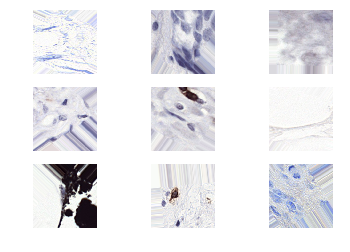

In [9]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True, 
                                     zoom_range=0.3, 
                                     width_shift_range=.3, 
                                     height_shift_range=.3)

fake_labels = np.random.rand(len(training_images))
fake_labels[fake_labels >= .5] = 1
fake_labels[fake_labels < .5] = 0

datagen.fit(training_images)

for X_batch, y_batch in datagen.flow(np.array(training_images), fake_labels, batch_size=9):
    plot_image(X_batch, images_per_row=3)
    break

### U-net architecture

In [52]:
# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
# This is based on the above repo. I tweaked it a fair bit but there's more we can do. We should also try other U-nets
# Something that this network benefits from is small dropout and I'm pretty sure we can go deeper. 

def get_unet(img_rows=512, img_cols=512, channels=3):
    # A common problem is that Keras might automatically detect "Channels first" or last. The below notation is "Channels last"
    # Which seems to be the default on cartesius. Problem, we only have once channel if we opt to only use the green channel
    #
    # Regarding input layer size - this does not seem to be our problem (Keras docs):
    # When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers,
    # does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in 
    # data_format="channels_last".
    
    # So flattening also does not force the data into our format (e.g. by using a Flatten() layer)
    
    # Our error seems to be related to https://github.com/keras-team/keras/issues/6351 which includes many miracle fixes
    # yet nothing for us.
    
    inputs = Input(shape=(img_rows, img_cols, channels))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
def get_secondunet(img_rows=512, img_cols=512, channels=3):
    inputs = Input(shape=(img_rows, img_cols, channels))
    # Unet taken fromDaniele Cortinovis https://github.com/orobix/retina-unet
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    #conv6 = core.Reshape((2,img_rows*img_cols))(conv6) 
    #conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Network parameters, from Francesco's paper:

* LR = 0.05
* Dropouts 0.5 (when?)
* SGD
* CCR (cross-entropy) loss
* F1-score

* RGB threshold on training imgs

Also 10 epochs with batch size 1. x20 resolution and 128x128 in- and output size 


In [9]:
def f1_score(y_true, y_pred):
    
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    f1 = f1[~np.isnan(f1)]
    
    return f1

In [27]:
print(img_patches[1].shape) #should be (512, 512, 3)

# Show patches (only green channel for now)
plt.subplot(211)
plt.imshow(img_patches[1])

plt.subplot(212)
plt.imshow(mask_patches[1])

(512, 512, 1)


TypeError: Invalid dimensions for image data

In [55]:
model = get_unet(512, 512, 1)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

In [64]:
X_train = np.asarray(img_patches)
y_train = np.asarray(mask_patches)

print(np.shape(X_train))
print(np.shape(y_train))

    

(20, 512, 512, 1)
(20, 512, 512, 1)


In [66]:
# model.fit_generator(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=10, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])
model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])

Train on 16 samples, validate on 4 samples
Epoch 1/10
 1/16 [>.............................] - ETA: 2:24 - loss: 7.1785 - acc: 0.0000e+00

KeyboardInterrupt: 